In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston 데이터 세트 로드
boston = load_boston()

#boston 데이터 세트 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격, 이를 PRICE 칼럼으로 DF에 추가 
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 : ', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 :  (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 각 칼럼이 회귀 결과에 미치는 영향이 어느정도인지 시각화 

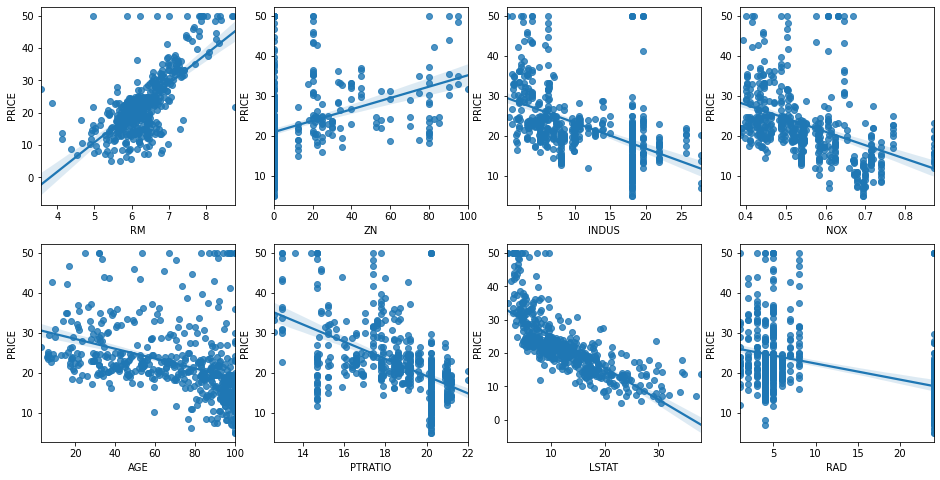

In [4]:
#2개의 행과 4개의 열을 가진 subplots 이용 axs는 4X2개의 ax를 가짐 
fig, axs=  plt.subplots(figsize = (16,8), ncols = 4, nrows = 2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i% 4
    #시본의 regplot을 이용해 산점도와 선형회귀 직선을 함꼐 표현
    sns.regplot(x=feature, y = 'PRICE', data = bostonDF, ax=axs[row][col])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis= 1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

#선형 회귀 OLS로 학습 / 예측 / 평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)

y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.306, RMSE : 4.160
Variance score : 0.757


linear regression으로 생성한 주택가격 모델의 intercept(절편)과 coefficients(회귀 계수)값 확인.

절편은 LinearRegression 객체의 intercept_ 속성에, 

회귀계수는 coef_ 속성에 값이 저장되어 있다.


In [11]:
print('절편 값 : ', lr.intercept_)
print('회귀 계수 값 : ', np.round(lr.coef_ , 1))

절편 값 :  40.995595172164556
회귀 계수 값 :  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


이것을 보기 쉽게 하려고 하지만, coef_ 속성에는 피처의 이름이 들어있지 않아 

별도로 넣어서 print 해야 한다.

In [12]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series 로 생성.인덱스 칼럼명에 유의
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### 5개의 폴드 세트에서 cross_val_score() 를 이용해 

교차 검증으로 MSE와 RMSE를 측정 ㅡㅡㅡ

In [15]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)
lr = LinearRegression()

#cross_val_score() 로 5폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores= cross_val_score(lr, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

#cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5folds 의 개별 Negative MSE scores :  [-12.48 -26.1  -33.12 -80.83 -33.58]
5folds 의 개별 RMSE scores :  [3.53 5.11 5.75 8.99 5.8 ]
5folds 의 평균 RMSE : 5.836
